In [1]:
# DATA
import pandas as pd 
import numpy as np
from sklearn.preprocessing import LabelEncoder
import gc

train_df = pd.read_csv("train.csv")
test_df  = pd.read_csv("test.csv")

le = LabelEncoder()

def feature_engineering(df,extras=False):  
    all_cols = ['Sex', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']
    categorical_cols = ['Sex']
    
    for c in categorical_cols:
        #df[c] = le.fit_transform(df[c]) # Converts categorical column into int format
        df[c] = df[c].astype('category') # Define column type as category 
        df[c] = df[c].cat.codes

    df['BMI'] = df['Weight'] / (df['Height'] / 100) ** 2
    df['Intensity'] = df['Heart_Rate'] / df['Duration']
    
    if extras:
        df['Age_bin6'] = pd.qcut(df['Age'], q=6, labels=[1, 2, 3, 4, 5, 6]).astype(int)
        df['Height_log10p'] = np.log10(df['Height']).astype(float)
        df['Sex_Weight_prod'] = df['Sex'] * df['Weight']
        df['Sex_Age_log10p_sum'] = df['Sex'] + np.log10(df['Age']).astype(float)
        df['Sex_Age_bin6_sum'] = df['Sex'] + pd.qcut(df['Age'], q=6, labels=[1, 2, 3, 4, 5, 6]).astype(int)
        df['Sex_Duration_log10p_prod'] = df['Sex'] * np.log10(df['Duration']).astype(float)
        df['Sex_Body_Temp_log10p_prod'] = df['Sex'] * np.log10(df['Body_Temp']).astype(float)
        df['Age_Age_bin6_ratio'] = df['Age'] / pd.qcut(df['Age'], q=6, labels=[1, 2, 3, 4, 5, 6]).astype(int)
        df['Height_Height_log10p_prod'] = df['Height'] * np.log10(df['Height']).astype(float)
        df['Height_Height_bin6_ratio'] = df['Height'] / pd.qcut(df['Height'], q=6, labels=[1, 2, 3, 4, 5, 6]).astype(int)
        df['Height_Duration_log1p_sum'] = df['Height'] + np.log1p(df['Duration'].astype(float))
        df['Heart_Rate_log10p_Duration_ratio'] = np.log10(df['Heart_Rate']).astype(float) / df['Duration']
        df['Body_Temp_bin6_Duration_ratio'] = pd.qcut(df['Body_Temp'], q=6, labels=[1, 2, 3, 4, 5, 6]).astype(int) / df['Duration']
        df['Heart_Rate_Heart_Rate_log10p_prod'] = df['Heart_Rate'] * np.log10(df['Heart_Rate']).astype(float)
        df['Body_Temp_Height_log10p_prod'] = df['Body_Temp'] * np.log10(df['Height']).astype(float)
        df['Body_Temp_Height_log1p_ratio'] = df['Body_Temp'] / np.log1p(df['Height']).astype(float)
        df['Body_Temp_Heart_Rate_log10p_diff'] = df['Body_Temp'] - np.log10(df['Heart_Rate']).astype(float)
        df['Age_bin6_Weight_log10p_diff'] = pd.qcut(df['Age'], q=6, labels=[1, 2, 3, 4, 5, 6]).astype(int) - np.log10(df['Weight']).astype(float)

    gc.collect()
    return df

catboost_test = test_df.copy()
catboost_test = feature_engineering(catboost_test,extras=True)

test_df = feature_engineering(test_df)
train_df = feature_engineering(train_df)

labels = train_df['Calories']
train_df.drop('Calories',axis=1,inplace=True)

train_df.describe()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,BMI,Intensity
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,374999.500000,0.499039,41.420404,174.697685,75.145668,15.421015,95.483995,40.036253,24.374817,10.547400
std,216506.495284,0.499999,15.175049,12.824496,13.982704,8.354095,9.449845,0.779875,1.511310,12.237710
min,0.000000,0.000000,20.000000,126.000000,36.000000,1.000000,67.000000,37.100000,12.375937,2.714286
25%,187499.750000,0.000000,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,23.255019,4.521739
50%,374999.500000,0.000000,40.000000,174.000000,74.000000,15.000000,95.000000,40.300000,24.391059,6.214286
75%,562499.250000,1.000000,52.000000,185.000000,87.000000,23.000000,103.000000,40.700000,25.487697,10.750000
max,749999.000000,1.000000,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,46.443986,108.000000


In [2]:
import xgboost as xgb
import catboost as cb 

first_model = xgb.XGBRegressor()
first_model.load_model("models/XGB_first.json")

second_model = xgb.XGBRegressor()
second_model.load_model("models/XGB_second.json")

third_model = cb.CatBoostRegressor()
third_model.load_model("models/catboost.json")


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

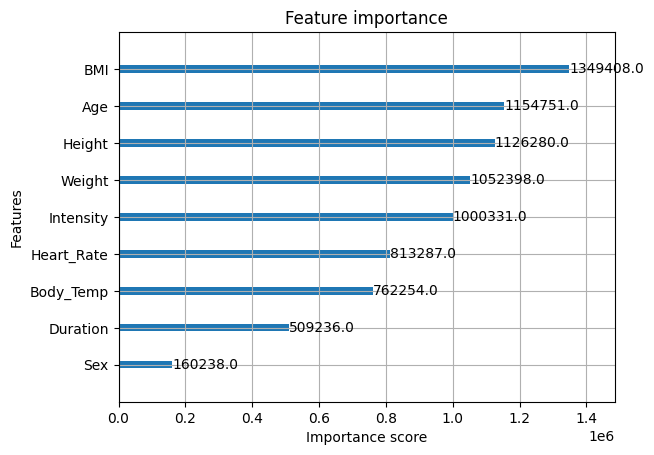

In [18]:
xgb.plot_importance(second_model)


In [6]:
preds1 = first_model.predict(test_df.drop("id",axis=1))

preds2 = second_model.predict(test_df.drop("id",axis=1))

preds3 = third_model.predict(catboost_test.drop(["id"],axis=1))
preds3 = np.expm1(preds3) 

ids = test_df["id"]

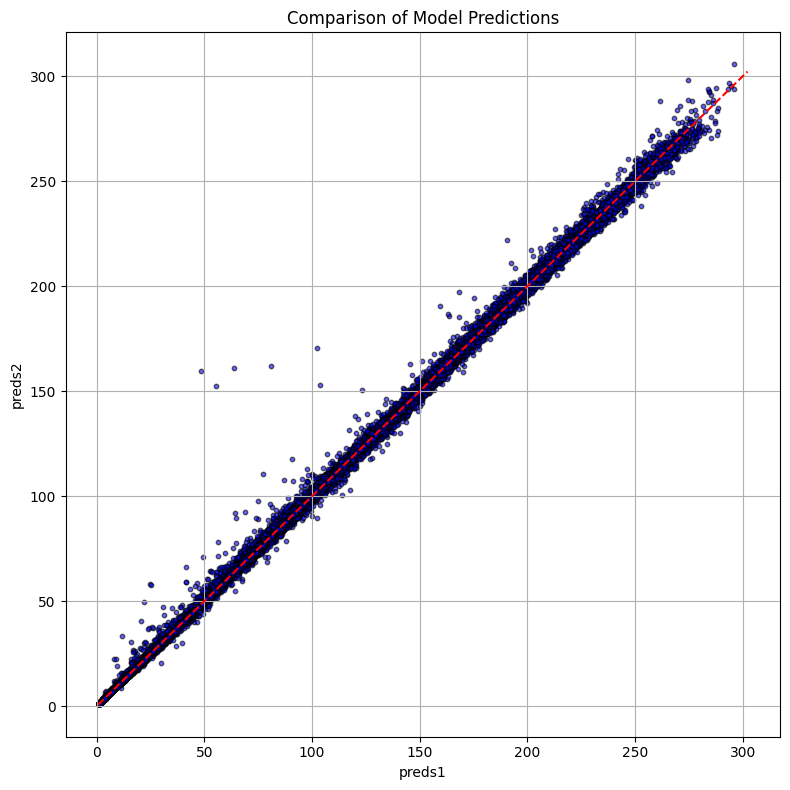

In [7]:
pred_frame = pd.DataFrame()

pred_frame["preds1"] = preds1
pred_frame["preds2"] = preds2
pred_frame["preds3"] = preds3
pred_frame["ids"] = ids

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.scatter(pred_frame["preds3"], pred_frame["preds2"], s=10, alpha=0.6, c='blue', edgecolors='k')
plt.plot([min(preds1), max(preds1)], [min(preds1), max(preds1)], color='red', linestyle='--')  # y = x line
plt.title("Comparison of Model Predictions")
plt.xlabel("preds1")
plt.ylabel("preds2")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np

preds1 = np.maximum(preds1, 0)
preds2 = np.maximum(preds2, 0)
preds3 = np.maximum(preds3, 0)


pred1_weighted = np.log1p(preds1)*0.1000
pred2_weighted = np.log1p(preds2)*0.1000
pred3_weighted = np.log1p(preds3)*0.8000


ensemble_preds = np.expm1(pred1_weighted + pred2_weighted + pred3_weighted)

submission = pd.DataFrame({"id": test_df["id"], "prediction": ensemble_preds})

submission.to_csv("submission.csv", index=False)
